<p align = "justify">

1. Import the data.

2. split to sets, normalization, build the model

3. evalute on the test set and plot.

In [1]:
import pandas as pd
import numpy as np
import datetime as dt
import time
from datetime import datetime, date, time, timedelta
from google.colab import data_table
import matplotlib.pyplot as plt
from matplotlib import pylab
import seaborn as sns
sns.set(style= "white",font_scale=1.5)
# Handle date time conversions between pandas and matplotlib
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
import matplotlib.dates as mdates
from calendar import month_abbr
from matplotlib.dates import DateFormatter
from matplotlib.pyplot import text
# Set the font to Times new roman
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = ['Times New Roman'] + plt.rcParams['font.serif']
import scipy as sp
from sklearn.model_selection import train_test_split
import sklearn.metrics as metrics
from sklearn import linear_model
from scipy import stats
!pip install torchinfo
from torchinfo import summary

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


1. Import the data:

a. CO2 data

b. temperature, RH, Radiation

In [2]:
path = ("/content/drive/MyDrive/Greenwall/co2_and_counting_people/Clean_data/01022021_02052022.csv")
df = pd.read_csv(path)
df['TIMESTAMP'] = pd.to_datetime(df['TIMESTAMP'])
df = df.set_index('TIMESTAMP')
df

,1,2,3,4,5,6,7,8,9,10
TIMESTAMP,,,,,,,,,,
2021-02-01 13:00:00,725.30,715.65,746.65,748.05,761.70,807.55,767.50,766.40,431.00,429.50
2021-02-01 13:30:00,902.50,832.00,838.00,851.50,851.00,851.00,851.00,842.50,433.65,431.85
2021-02-01 14:00:00,856.00,863.00,871.00,875.50,884.00,882.00,875.50,891.50,438.10,434.10
2021-02-01 14:30:00,922.00,910.00,918.50,923.00,921.00,921.00,921.00,939.50,447.25,437.90
2021-02-01 15:00:00,814.00,783.10,750.85,707.75,688.95,693.20,707.20,718.30,433.85,431.25
...,...,...,...,...,...,...,...,...,...,...
2022-05-02 08:45:00,414.45,418.00,422.50,417.30,417.30,417.30,444.10,446.15,375.60,374.60
2022-05-02 09:15:00,442.15,443.35,446.35,441.55,449.60,460.95,460.15,459.40,376.40,375.70
2022-05-02 09:45:00,462.65,467.40,468.55,462.30,462.30,462.30,464.75,461.30,374.70,374.60


LoggerNet data:

In [3]:
new_file_path = "/content/drive/MyDrive/Greenwall/LoggerNet_files/latest_03062022.csv" #until 31/05/2022
df_logger = pd.read_csv(new_file_path) # reading the raw date (csv)
df_logger = df_logger[3:]

# make 'Time' the dataframe index
df_logger['TIMESTAMP'] = pd.to_datetime(df_logger['TIMESTAMP'])
df_logger = df_logger.set_index('TIMESTAMP')
df_logger =df_logger.astype(float, errors = 'raise') #change dtype to float

# keep with relevant columns:
df_logger = df_logger[['Temp_out_Avg','Rh_out_Avg','Par_Avg']]
# rename the column names:
df_logger.columns = ['Temp_out','RH_out','Par_out']
# df_logger.describe()
# df_logger.dtypes
df_logger = df_logger.loc[:"2022-06-01 00:00:00"] #set the final date
df_logger = df_logger.resample("30min").mean()
df_logger

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:3326: DtypeWarning: Columns (1,2,3,4,5,6,7,8,9) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


,Temp_out,RH_out,Par_out
TIMESTAMP,,,
2021-05-25 13:00:00,28.548000,47.948000,3650.750000
2021-05-25 13:30:00,30.206167,50.330833,2044.440678
2021-05-25 14:00:00,30.307833,50.929000,1965.550000
2021-05-25 14:30:00,30.434000,50.398667,1849.833333
2021-05-25 15:00:00,30.077167,51.037667,1699.516667
...,...,...,...
2022-05-31 22:00:00,22.993000,84.728333,0.017667
2022-05-31 22:30:00,22.600167,85.950000,0.019583
2022-05-31 23:00:00,22.246667,86.866667,0.044700


In [4]:
df1 = df[['10']]
df1 = df1.loc["2021-05-25 13:00:00":"2022-06-01 00:00:00"]
df1 = df1.resample("30min").mean()
df1

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  


,10
TIMESTAMP,
2021-05-25 13:00:00,419.45
2021-05-25 13:30:00,419.25
2021-05-25 14:00:00,419.45
2021-05-25 14:30:00,421.35
2021-05-25 15:00:00,423.40
...,...
2022-05-02 08:30:00,374.60
2022-05-02 09:00:00,375.70
2022-05-02 09:30:00,374.60


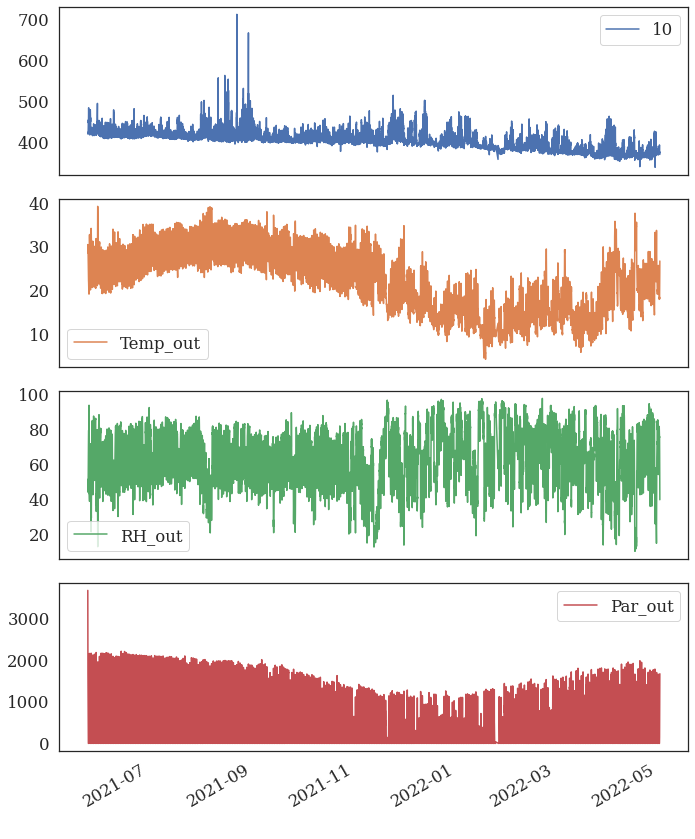

In [5]:
# merge the data
df = df1.join(df_logger, how='right')
df = df[df['10']>=200] #delete 0 values CO2
# df = df[df['9']>=200] #delete 0 values CO2

# df.to_csv("/content/drive/MyDrive/gdrive_folder/CO2_LSTM/data")
axes = df.plot(subplots=True, figsize=(10, 12),xlabel = " ")
# axes[0].set_ylabel('Temperature (C$^\circ$)',fontsize = 17)
# axes[1].set_ylabel('RH (%)',fontsize = 17)
# axes[2].set_ylabel('Temperature (C$^\circ$)',fontsize = 17)
# axes[3].set_ylabel('RH (%)',fontsize = 17)
plt.tight_layout()
# save_results_to = '/content/drive/MyDrive/Greenwall/temperture_rh_data/Charts/'
# plt.savefig(save_results_to + 'one_hour_resample_time_series.png')

/usr/local/lib/python3.7/dist-packages/seaborn/matrix.py:654: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


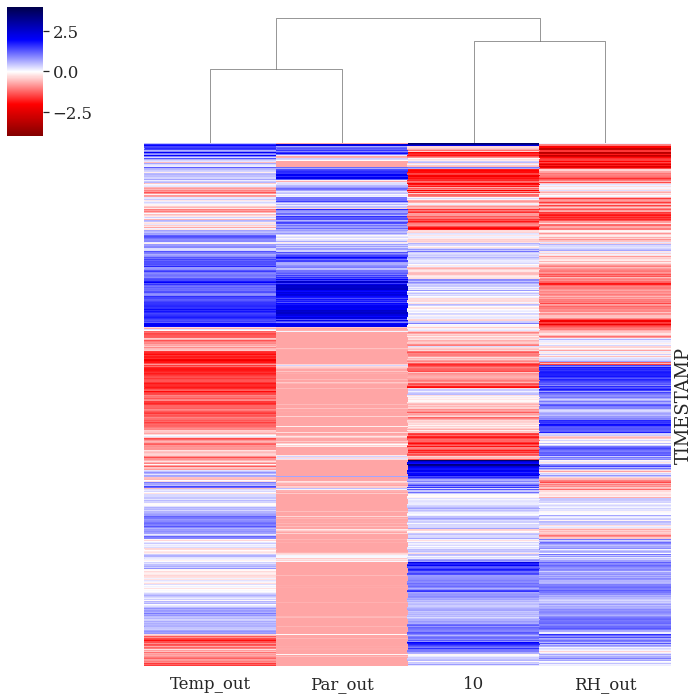

In [6]:
# plot a clustermap :
cg = sns.clustermap(data = df,
               z_score = True,
               cmap = 'seismic_r',
               vmin = -4,
               vmax = 4,
               yticklabels=False
              )
cg.ax_row_dendrogram.set_visible(False)
plt.show()

## Linear Regression

create features and labels:

In [7]:
features = df[['Temp_out', 'RH_out', 'Par_out']]
labels = np.array(df['10']).reshape(-1, 1)

2. Standardization and split to train, validation and test

In [8]:
#standardize the values for each predictor variable
features = (features-features.mean())/features.std()
features

,Temp_out,RH_out,Par_out
TIMESTAMP,,,
2021-05-25 13:00:00,0.900968,-0.900210,5.255248
2021-05-25 13:30:00,1.131459,-0.758968,2.635424
2021-05-25 14:00:00,1.145591,-0.723511,2.506757
2021-05-25 14:30:00,1.163129,-0.754947,2.318028
2021-05-25 15:00:00,1.113528,-0.717070,2.072867
...,...,...,...
2022-05-02 08:00:00,-0.061536,-0.241202,0.960527
2022-05-02 08:30:00,0.148961,-0.588217,1.276063
2022-05-02 09:00:00,0.236139,-0.817650,1.547508


Split the data:

In [9]:
train_ratio = 0.8
test_ratio = 0.2
# train is now 70% of the entire data set
# the _junk suffix means that we drop that variable completely
x_train, x_test, y_train, y_test = train_test_split(features,
                                                    labels,
                                                    test_size=1 - train_ratio)
# Split to val-test
val_ratio = 0.5
x_val, x_test, y_val, y_test = train_test_split(x_test,
                                                    y_test,
                                                    test_size=val_ratio)

print("x train length: ",len(x_train),"\n","x validation length: ", len(x_val),"\n","x test length: ", len(x_test))

x train length:  13029 
 x validation length:  1629 
 x test length:  1629


In [10]:
# Apply linear model:
clf = linear_model.SGDRegressor()
clf.fit(x_train, y_train)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


SGDRegressor()

In [11]:
# predict and evaluate on the sets
y_val_pred = clf.predict(x_val)

print("Train: score:",clf.score(x_train, y_train))
print("Validation: score:",clf.score(x_val, y_val))

Train: score: 0.2732564146949069
Validation: score: 0.25846692717700914


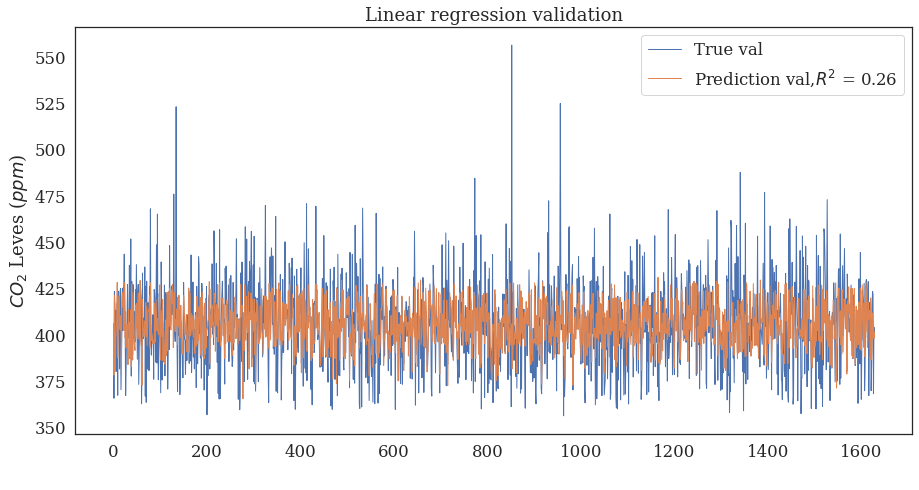

In [12]:
fig, ax = plt.subplots(1, figsize=(15,7.5))
ax.plot(y_val,label='True val',  linewidth=1)
ax.plot(y_val_pred,label=f'Prediction val,$R^2$ = {round(clf.score(x_val, y_val),2)}',  linewidth=1)
ax.set(xlabel=" ",
       ylabel="$CO_2$ Leves ($ppm$)",
       title="Linear regression validation");
plt.legend(loc='best')
# plt.gcf().autofmt_xdate()  # makes slated dates

## LSTM 2

Based on [this](https://www.crosstab.io/articles/time-series-pytorch-lstm) tutorial

For our forecasting target, we need to shift the CO2 column forward in time. Let's forecast 1 hour in the future, which is 2 30 minutes periods. The newly created target column won't have values in the final **0** rows, so we'll drop those.

In [57]:
df_lstm = df
df_lstm

,10,Temp_out,RH_out,Par_out,10_lead1
TIMESTAMP,,,,,
2021-05-25 13:00:00,419.45,28.548000,47.948000,3650.750000,419.45
2021-05-25 13:30:00,419.25,30.206167,50.330833,2044.440678,419.25
2021-05-25 14:00:00,419.45,30.307833,50.929000,1965.550000,419.45
2021-05-25 14:30:00,421.35,30.434000,50.398667,1849.833333,421.35
2021-05-25 15:00:00,423.40,30.077167,51.037667,1699.516667,423.40
...,...,...,...,...,...
2022-05-02 08:00:00,375.70,21.623667,59.065833,1017.500000,375.70
2022-05-02 08:30:00,374.60,23.138000,53.211500,1210.966667,374.60
2022-05-02 09:00:00,375.70,23.765167,49.340833,1377.400000,375.70


In [58]:
target_x = "10"
features = list(df_lstm.columns.difference([target_x]))

forecast_lead = 1
target = f"{target_x}_lead{forecast_lead}"
# if you want to add lead uncomment the next 2 lines:
df_lstm[target] = df_lstm[target_x].shift(-forecast_lead)
df_lstm = df_lstm.iloc[:-forecast_lead]

# if you DONT want to add lead uncomment the next  line:
# df_lstm[target] = df_lstm[target_x] 


**Create a hold-out test set and preprocess the data**


As always, we need a test set to evaluate our model. Here, we'll keep it simple with a single temporal split, i.e. our test set is the last **11** days of data (about 20% of the total).

The Scikit-learn [user guide](https://scikit-learn.org/stable/modules/cross_validation.html#time-series-split) has a good discussion of temporal vs. random splits, if this is unfamiliar territory.

**Standardize the features and target**


In my experience, standardizing both the features and the target seems to help substantially. This can also be done with Scikit-learn, but it's really not that much code to do it with Python dictionaries and in this case, we really only need to keep the mean and standard deviation of the target column.

In [59]:
# Standardization:
target_mean = df_lstm[target].mean() # we need this value for evaluation
target_stdev = df_lstm[target].std() # we need this value for evaluation

df_lstm = (df_lstm-df_lstm.mean())/df_lstm.std()


# Train +validation
df_train = df_lstm.sample(frac = 0.7) # 70% for train



# Test:
df_test = df_lstm.drop(df_train.index)
# split the test to validation and test
df_val = df_test.sample(frac = (0.5)) # 15% for validation (0.5*0.3)
df_test = df_test.drop(df_val.index)


print("x train length: ",len(df_train),
      "\n","x validation length: ", len(df_val),
      "\n","x test length: ", len(df_test))

x train length:  11400 
 x validation length:  2443 
 x test length:  2443


Typically, time series regression tutorials lessons show how to create features by extracting parts of the timestamps or by lagging features, that is, using past values of each feature as features in their own right. That's not what we're going to do with the LSTM; for each training instance, we're going to give the model a sequence of observations.

One elegant way to do this is to create a PyTorch Dataset class, which is simpler than you might think. This strategy lets us lean on PyTorch's nice DataLoader class to keep the model training and evaluation code super clean.

Our custom Dataset just needs to specify what happens when somebody requests the i'th element of the dataset. In a tabular dataset, this would be the i'th row of the table, but here we need to retrieve a sequence of rows.

So, given i and the sequence_length, we return the block of data from i - sequence_length through row i. If i is at the beginning of the dataset, we pad by repeating the first row as many times as needed to make the output have sequence_length rows. The only trick is avoiding off-by-1 errors in the slicing and padding.

All the magic happens in the __getitem__ method in this snippet.

In [60]:
import torch
from torch.utils.data import Dataset

class SequenceDataset(Dataset):
    def __init__(self, dataframe, target, features, sequence_length=5):
        self.features = features
        self.target = target
        self.sequence_length = sequence_length
        self.y = torch.tensor(dataframe[target].values).float()
        self.X = torch.tensor(dataframe[features].values).float()

    def __len__(self):
        return self.X.shape[0]

    def __getitem__(self, i): 
        if i >= self.sequence_length - 1:
            i_start = i - self.sequence_length + 1
            x = self.X[i_start:(i + 1), :]
        else:
            padding = self.X[0].repeat(self.sequence_length - i - 1, 1)
            x = self.X[0:(i + 1), :]
            x = torch.cat((padding, x), 0)

        return x, self.y[i]

Let's look at a small example to build intuition about how it works. Namely, let's grab the 27'th entry in the dataset with a sequence length of 4

In [61]:
i = 27
sequence_length = 4

train_dataset = SequenceDataset(
    df_train,
    target=target,
    features=features,
    sequence_length=sequence_length
)

X, y = train_dataset[i]
print(X)

tensor([[-0.4268, -0.6989,  1.8238, -1.6013],
        [ 0.8866, -0.6916, -0.5471,  1.2191],
        [-0.4937,  0.2655,  0.5302, -0.0267],
        [-0.4558, -0.6985,  1.4776, -1.5312]])


Create validation dataset

In [62]:
val_dataset = SequenceDataset(
    df_val,
    target=target,
    features=features,
    sequence_length=sequence_length
)

X, y = val_dataset[i]
print(X)

tensor([[-0.0879, -0.5721, -0.2343, -1.6149],
        [ 0.7149, -0.6989,  1.0350,  0.8171],
        [-0.9754, -0.6989,  1.2079, -0.7714],
        [-0.8706, -0.2858,  1.4329, -1.5152]])


Our output feature tensor has a column for each of the 3 input columns, and a row for each of the four time steps in the sequence. The last row is row 27 of the original table.

If we take index 28 instead, we see the rows are shifted forward in time by 1 step. The oldest row is popped off the back and row 28 is pushed onto the front.

In [63]:
X, y = train_dataset[i + 1]
print(X)

tensor([[ 0.8866, -0.6916, -0.5471,  1.2191],
        [-0.4937,  0.2655,  0.5302, -0.0267],
        [-0.4558, -0.6985,  1.4776, -1.5312],
        [ 0.4719,  2.2167, -0.9409,  1.4091]])


Just to confirm, here's the same logic for item 27, with Pandas DataFrame slicing.

In [64]:
print(df_train[features].iloc[(i - sequence_length + 1): (i + 1)])
print(df_val[features].iloc[(i - sequence_length + 1): (i + 1)])

                     10_lead1   Par_out    RH_out  Temp_out
TIMESTAMP                                                  
2021-12-20 17:30:00 -0.426812 -0.698905  1.823752 -1.601300
2021-08-03 19:30:00  0.886643 -0.691616 -0.547134  1.219141
2021-11-19 12:00:00 -0.493711  0.265506  0.530248 -0.026653
2022-02-27 05:30:00 -0.455801 -0.698514  1.477577 -1.531174
                     10_lead1   Par_out    RH_out  Temp_out
TIMESTAMP                                                  
2022-01-12 07:00:00 -0.087856 -0.572065 -0.234341 -1.614922
2021-08-12 00:30:00  0.714935 -0.698888  1.035008  0.817128
2022-03-30 19:00:00 -0.975385 -0.698886  1.207868 -0.771396
2022-02-11 07:30:00 -0.870576 -0.285796  1.432922 -1.515235


The next step is to set the dataset in a PyTorch DataLoader, which will draw minibatches of data for us.

Let's try a small batch size of 3, to illustrate. The feature tensor returned by a call to our train_loader has shape 3 x 4 x 3, which reflects our data structure choices:

* 3: batch size
* 4: sequence length
* 3: number of features

In [66]:
from torch.utils.data import DataLoader
torch.manual_seed(99)

train_loader = DataLoader(train_dataset, batch_size=3, shuffle=True)

X, y = next(iter(train_loader))
print(X.shape)
print(X)
torch.Size([3, 4, 5])

torch.Size([3, 4, 4])
tensor([[[ 0.0794, -0.6989, -0.2598,  0.6367],
         [ 0.3358,  1.8490, -0.3006,  1.4050],
         [ 0.6926, -0.6989,  0.4300,  0.3309],
         [ 0.5722, -0.6989,  1.5043, -1.0195]],

        [[ 0.2533, -0.5982, -0.0427,  1.0487],
         [ 0.6235, -0.6989,  0.6882, -1.6641],
         [-0.6565,  1.1361, -1.5104, -0.3529],
         [-0.4179, -0.6989, -0.9332, -0.7369]],

        [[ 0.4964, -0.6135, -0.8646,  0.3484],
         [ 0.1396,  1.2161, -0.6039,  0.7062],
         [ 0.2846, -0.6989,  0.7230,  0.2057],
         [ 0.9580, -0.6989,  1.2696,  0.5865]]])


torch.Size([3, 4, 5])

Here we can see illustration for **5** features

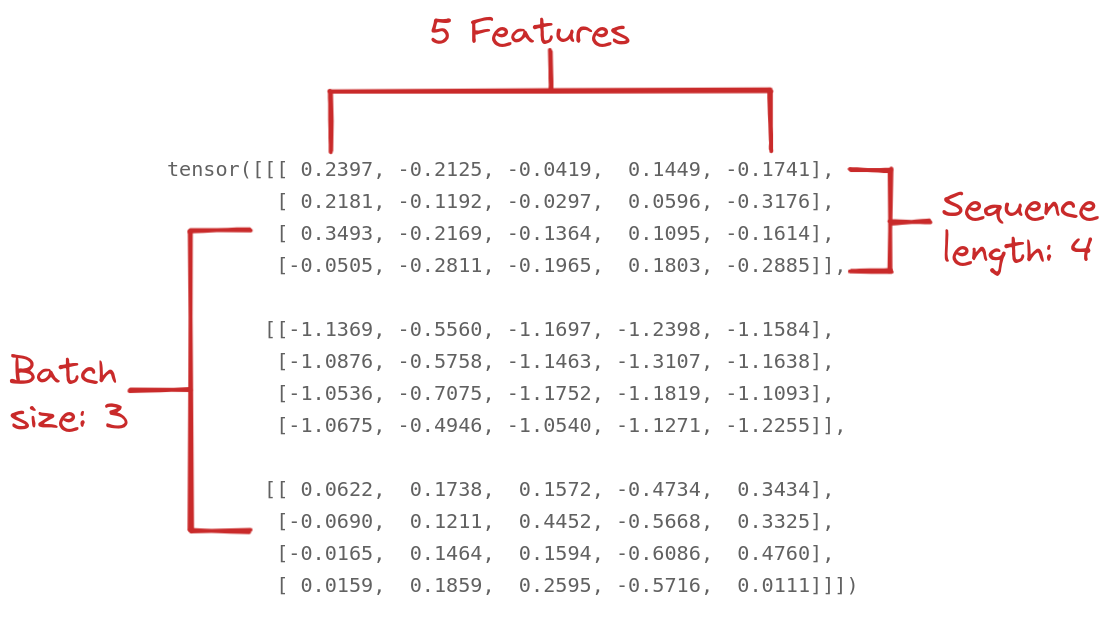

**Create the datasets and data loaders for real**

Now let's do it for real, with a sequence of 24 time steps (12 hours). For training, we'll shuffle the data (the rows within each data sequence are not shuffled, only the order in which we draw the blocks). For the test set, shuffling isn't necessary.

In [67]:
torch.manual_seed(101)

batch_size = 4
sequence_length = 50

# Train
train_dataset = SequenceDataset(
    df_train,
    target=target,
    features=features,
    sequence_length=sequence_length
)
# Validation
val_dataset = SequenceDataset(
    df_val,
    target=target,
    features=features,
    sequence_length=sequence_length
)
# Test
test_dataset = SequenceDataset(
    df_test,
    target=target,
    features=features,
    sequence_length=sequence_length
)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

X, y = next(iter(train_loader))

print("Features shape:", X.shape)
print("Target shape:", y.shape)

Features shape: torch.Size([4, 50, 4])
Target shape: torch.Size([4])


**The model and learning algorithm**


With the hard data structure part done, now it's all downhill from here! A few notes to highlight in the *ShallowRegressionLSTM* model below:

* Most importantly, we have to keep track of which dimension represents the batch in our input tensors. As we just saw, our data loaders use the first dimension for this, but the PyTorch LSTM layer's default is to use the second dimension instead. So **we set batch_first=True to make the dimensions line up**, but confusingly, this doesn't apply to the hidden and cell state tensors. In the forward method, we initialize h0 and c0 with batch size as the second dimension.

* We'll hard code a single layer just to keep things simple.

* The output layer of the model is linear with a single output unit because we're doing regression. This is one of only two lines of code that would need to change for a classification task.

In [68]:
from torch import nn

class ShallowRegressionLSTM(nn.Module):
    def __init__(self, num_features, hidden_units):
        super().__init__()
        self.num_sensors = num_features  # this is the number of features
        self.hidden_units = hidden_units
        self.num_layers = 1

        self.lstm = nn.LSTM(
            input_size=num_features,
            hidden_size=hidden_units,
            batch_first=True,
            num_layers=self.num_layers
        )

        self.linear = nn.Linear(in_features=self.hidden_units, out_features=1)

    def forward(self, x):
        batch_size = x.shape[0]
        h0 = torch.zeros(self.num_layers, batch_size, self.hidden_units).requires_grad_()
        c0 = torch.zeros(self.num_layers, batch_size, self.hidden_units).requires_grad_()

        _, (hn, _) = self.lstm(x, (h0, c0))
        out = self.linear(hn[0]).flatten()  # First dim of Hn is num_layers, which is set to 1 above.

        return out

The other thing that would need to change is the **loss function**. Here we use the standard regression objective of mean square error, i.e. *MSELoss*.

In [69]:
learning_rate = 0.0001
num_hidden_units = 10
Epochs = 5

model = ShallowRegressionLSTM(num_features=len(features), hidden_units=num_hidden_units)
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [70]:
print(summary(model)) # This helps to visualize the model structure

Layer (type:depth-idx)                   Param #
ShallowRegressionLSTM                    --
├─LSTM: 1-1                              640
├─Linear: 1-2                            11
Total params: 651
Trainable params: 651
Non-trainable params: 0


**Training**


Time to get the ship underway!

The train_model and test_model functions below are standard PyTorch boilerplate; there is nothing in them specific to LSTMs or time series data. But that's the point: by using a custom PyTorch Dataset and a DataLoader, we can use off-the-shelf training and evaluation loops.

In [71]:
def train_model(data_loader, model, loss_function, optimizer):
    num_batches = len(data_loader)
    total_loss = 0
    model.train()
    train_history_loss = []
    for X, y in data_loader:
        output = model(X)
        loss = loss_function(output, y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    avg_loss = total_loss / num_batches
    # train_history_loss += avg_loss
    print(f"Train loss: {avg_loss}")
    
    return train_history_loss

def val_model(data_loader, model, loss_function):
    val_history_loss = []
    num_batches = len(data_loader)
    total_loss = 0

    model.eval()
    with torch.no_grad():
        for X, y in data_loader:
            output = model(X)
            total_loss += loss_function(output, y).item()

    avg_loss = total_loss / num_batches
    print(f"Validation loss: {avg_loss}")
    

print("Untrained validation\n--------")
val_model(val_loader, model, loss_function)
print()

for ix_epoch in range(Epochs):
    print(f"Epoch {ix_epoch}\n---------")
    train_model(train_loader, model, loss_function, optimizer=optimizer)
    val_model(val_loader, model, loss_function)
    print()

Untrained validation
--------
Validation loss: 0.9741533702382674

Epoch 0
---------
Train loss: 0.7651264951043157
Validation loss: 0.43338492704778697

Epoch 1
---------
Train loss: 0.29069756779648165
Validation loss: 0.14679171918613335

Epoch 2
---------
Train loss: 0.11729415971648945
Validation loss: 0.06467704536568003

Epoch 3
---------
Train loss: 0.05962905237634308
Validation loss: 0.03580720926275909

Epoch 4
---------
Train loss: 0.04152956259227435
Validation loss: 0.02545339517978086



**Evaluation**
Evaluating the model is straightforward. 

First, let's define a variant of the test function that actually returns the predictions. We also need a **new DataLoader for the training set that isn't shuffled**, we can visualize the training and test set predictions chronologically. Lastly, it's nice to **un-standardize the predictions** so they're back in their original units of micrograms per cubic meter.

In [72]:
def predict(data_loader, model):

    output = torch.tensor([])
    model.eval()
    with torch.no_grad():
        for X, _ in data_loader:
            y_star = model(X)
            output = torch.cat((output, y_star), 0)

    return output


train_eval_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
test_eval_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

ystar_col = "Model forecast"
df_train[ystar_col] = predict(train_eval_loader, model).numpy()
df_test[ystar_col] = predict(test_eval_loader, model).numpy()

df_out = pd.concat((df_train, df_test))[[target, ystar_col]]

for c in df_out.columns:
    df_out[c] = df_out[c] * target_stdev + target_mean

df_out = df_out.sort_index() # sort the shuffle 
print(df_out)

                     10_lead1  Model forecast
TIMESTAMP                                    
2021-05-25 13:00:00    419.25      421.509552
2021-05-25 13:30:00    419.45      421.986603
2021-05-25 14:00:00    421.35      423.881287
2021-05-25 14:30:00    423.40      426.691589
2021-05-25 15:00:00    422.65      425.408813
...                       ...             ...
2022-05-02 07:30:00    375.70      372.601379
2022-05-02 08:00:00    374.60      375.269440
2022-05-02 08:30:00    375.70      374.725067
2022-05-02 09:00:00    374.60      374.449127
2022-05-02 09:30:00    369.30      368.487030

[13843 rows x 2 columns]


In [73]:
slope, intercept, r_value, p_value, std_err = stats.linregress(df_out['Model forecast'], df_out['10_lead1'])

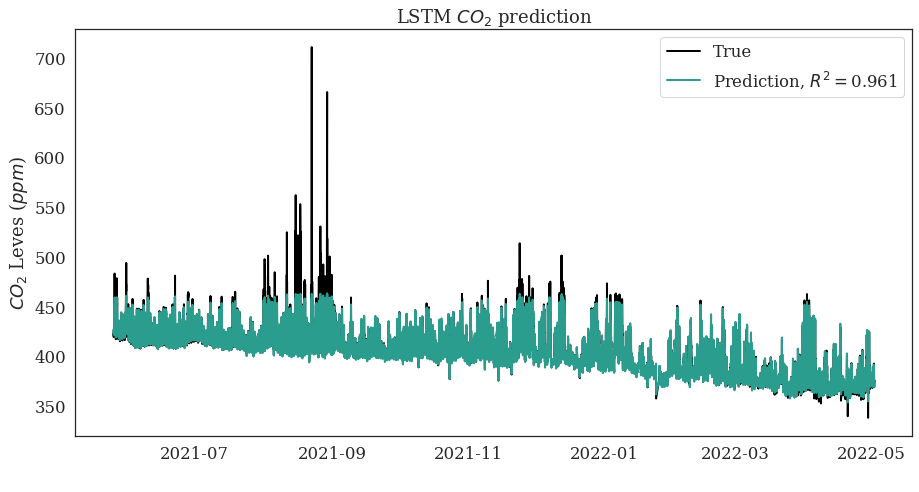

In [76]:
fig, ax = plt.subplots(1, figsize=(15,7.5))
ax.plot(df_out.index,df_out['10_lead1'],label='True', linewidth=2, color = "black")
ax.plot(df_out.index,df_out['Model forecast'],label=f'Prediction, $R^2 = ${round(r_value**2,3)}', linewidth=2, color="#2a9d8f")
ax.set(xlabel=" ",
       ylabel="$CO_2$ Leves ($ppm$)",
       title="LSTM $CO_2$ prediction");
plt.legend(loc='best')
# plt.gcf().autofmt_xdate()  # makes slated dates

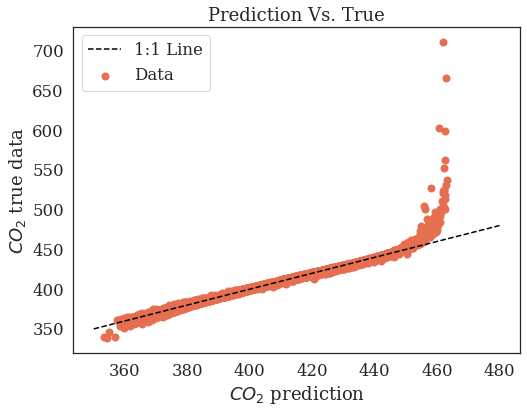

In [75]:
fig, ax = plt.subplots(1, figsize=(8,6))
ax.scatter(df_out['Model forecast'],df_out['10_lead1'],label='Data', linewidth=2, color="#e76f51")
xy_line = [350, 480]
ax.plot(xy_line,xy_line, color = 'black',ls = "--" ,label='1:1 Line')

ax.set(xlabel="$CO_2$ prediction",
       ylabel="$CO_2$ true data",
       title="Prediction Vs. True");
plt.legend(loc='best')

* As you can see the prediction of the model is very good ($R^2 = 0.95, MSE = 0.13$). 

* The error is mainly in high values of $CO_2$. The reason for this can be due to external pollution. The factors with which we predicted the $CO_2$ levels affect the photosynthesis  of plants which directly affects the $CO_2$ levels. **These factors cannot predict other environmental changes such as for example Exhaust from cars or industry**.